### Figure 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import pyproj
from datetime import datetime, timedelta
from xhistogram.xarray import histogram
import matplotlib.ticker as mticker
import intake

In [2]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45135/status,
Dashboard: /proxy/45135/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34885,Workers: 0
Dashboard: /proxy/45135/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45379,Total threads: 1
Dashboard: /proxy/42835/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:33123,


In [14]:
def multi_corr(ts,infield,t = 2.2, amp = 'no'):
    # Try to calculate the maps below by using matrix multiplication instead: 
    fshape = infield.shape
    dims = len(infield.shape)-1
    N = ts.shape[0]
    r1, tmp = scipy.stats.pearsonr(ts[1:], np.roll(ts, 1)[1:])
    Neff = N*(1-r1*r1)/(1+r1*r1)
    
    if dims ==2:
        regression = np.empty((fshape[1], fshape[2]))
    elif dims ==3:
        regression = np.empty((fshape[1], fshape[2],fshape[3]))
    regression.shape

    ts_norm = (ts-np.nanmean(ts))/np.nanstd(ts)
    if amp =='no':
        field_norm = (infield-infield.mean('time'))/infield.std('time')
    else: field_norm = (infield-infield.mean('time'))
    if dims ==2:
        field_2D = np.reshape(field_norm.values,(N,fshape[1]*fshape[2]))
        regression = np.reshape(np.matmul(ts_norm.values,field_2D)/N,(fshape[1],fshape[2]))
    elif dims == 3:
        field_2D = np.reshape(field_norm.values,(N,fshape[1]*fshape[2]*fshape[3]))
        regression = np.reshape(np.matmul(ts_norm.values,field_2D)/N,(fshape[1],fshape[2],fshape[3]))

    reg_xr = infield.mean('time').load()
    reg_xr.values = regression
    thres = t/np.sqrt(Neff-2+t*t)
    
    return reg_xr, thres

In [4]:
# Load observational data

# Paolo melt rates
# Load melt datasets:
melt_dataset = xr.open_dataset('/g/data/jk72/or6852/ANT_G1920V01_IceShelfMelt.nc',engine='netcdf4')
# calculate lon and lat of the basal melt file \n",
inProj = Proj(init='epsg:3031')
outProj = Proj(init='epsg:4326')
bas_lon,bas_lat = transform(inProj,outProj,melt_dataset.melt_mean.x,melt_dataset.melt_mean.y)
x2d, y2d = np.meshgrid(melt_dataset.melt.x, melt_dataset.melt.y)
bas_lon2d,bas_lat2d = transform(inProj,outProj,x2d, y2d)
melt_dataset.coords['lat'] = (melt_dataset.melt_mean.dims, bas_lat2d)
melt_dataset.coords['lon'] = (melt_dataset.melt_mean.dims, bas_lon2d)
pib_meltid = melt_dataset.melt.where(melt_dataset.ID.isin([54,55, 56,181,182])).where(~np.isnan(melt_dataset.melt[-1,:,:])).mean({'x','y'})# IDs for Crosson, PIG, Cosgrove, Thwaites W, Thwaites E, 

# Davison melt rates
dav_pig = pd.read_csv('/g/data/jk72/or6852/ensoant/Pine_Island-timeseries.csv',parse_dates=[1])
dav_pig_melt = xr.DataArray(dav_pig['bm_monthly'],dims={'time':dav_pig.dates_datetime},coords={'time':dav_pig.dates_datetime,'area':dav_pig.area_km2[0]})
dav_abb = pd.read_csv('/g/data/jk72/or6852/ensoant/Abbot-timeseries.csv',parse_dates=[1])
dav_abb_melt = xr.DataArray(dav_abb['bm_monthly'],dims={'time':dav_abb.dates_datetime},coords={'time':dav_abb.dates_datetime,'area':dav_abb.area_km2[0]})
dav_cos = pd.read_csv('/g/data/jk72/or6852/ensoant/Cosgrove-timeseries.csv',parse_dates=[1])
dav_cos_melt = xr.DataArray(dav_cos['bm_monthly'],dims={'time':dav_cos.dates_datetime},coords={'time':dav_cos.dates_datetime,'area':dav_cos.area_km2[0]})
dav_cro = pd.read_csv('/g/data/jk72/or6852/ensoant/Crosson-timeseries.csv',parse_dates=[1])
dav_cro_melt = xr.DataArray(dav_cro['bm_monthly'],dims={'time':dav_cro.dates_datetime},coords={'time':dav_cro.dates_datetime,'area':dav_cro.area_km2[0]})
dav_dot = pd.read_csv('/g/data/jk72/or6852/ensoant/Dotson-timeseries.csv',parse_dates=[1])
dav_dot_melt = xr.DataArray(dav_dot['bm_monthly'],dims={'time':dav_dot.dates_datetime},coords={'time':dav_dot.dates_datetime,'area':dav_dot.area_km2[0]})
dav_get = pd.read_csv('/g/data/jk72/or6852/ensoant/Getz-timeseries.csv',parse_dates=[1])
dav_get_melt = xr.DataArray(dav_get['bm_monthly'],dims={'time':dav_get.dates_datetime},coords={'time':dav_get.dates_datetime,'area':dav_get.area_km2[0]})
dav_thw = pd.read_csv('/g/data/jk72/or6852/ensoant/Thwaites-timeseries.csv',parse_dates=[1])
dav_thw_melt = xr.DataArray(dav_thw['bm_monthly'],dims={'time':dav_thw.dates_datetime},coords={'time':dav_thw.dates_datetime,'area':dav_thw.area_km2[0]})
dav_conc = xr.concat([dav_pig_melt,dav_thw_melt,dav_cos_melt,dav_cro_melt,dav_abb_melt,dav_dot_melt,dav_get_melt],dim='IS')
dav_pib_melt = dav_conc[:4,:].weighted(dav_conc[:4,:].area).mean('IS')

# CTDs

# Load mooring data:
mooring = xr.open_dataset('/g/data/jk72/or6852/as_obs/OceMoor2_MIPkitA_PIGS.nc',decode_times=False)
t_moor = mooring.thetao
mooringn = xr.open_dataset('/g/data/jk72/or6852/as_obs/OceMoor1_MIPkitA_PIGN.nc',decode_times=False)
t_moorn = mooringn.thetao
moortime = []
for i in range(len(t_moor.time)):
    moortime.append(datetime(int(t_moor.time[i].values),1,1)+timedelta(t_moor.time[i].values % 1 *365))

t_moor = t_moor.assign_coords(time = xr.DataArray(moortime,dims='time'))
t_moorn = t_moorn.assign_coords(time = xr.DataArray(moortime,dims='time'))

In [5]:
# Load CTD obs from the southern Amundsen Sea
import os
import glob
oce_paths = sorted(glob.glob('/g/data/jk72/or6852/as_obs/Oce3d_MIPkitA_*.nc'))
oce_paths = np.concatenate((oce_paths[:9],oce_paths[10:])) # skip 2019 as there are no obs in our box
oce_data = list([])
pib_obs = []
as_obs = []
#pig = []
for i in range(len(oce_paths)):
    oce_data.append(xr.open_dataset(oce_paths[i]))
    pib_mask_obs = xr.where(np.logical_or(((oce_data[i].lon>-110) & (oce_data[i].lat<-74.5) & (oce_data[i].lon<-100)),((oce_data[i].lon>-103.5) & (oce_data[i].lon<-100) & (oce_data[i].lat<-73.2))),1,np.nan)
    as_mask_obs = xr.where(((oce_data[i].lon>-120) & (oce_data[i].lat<-72) & (oce_data[i].lon<-100)),1,np.nan)
    pib_avg = (oce_data[i].thetao*pib_mask_obs).mean('lon').assign_coords(time = datetime.fromisocalendar(int(oce_paths[i][-7:-3]),7,1))
    pib_obs.append((oce_data[i].lon*pib_mask_obs).dropna(dim='lon').shape[0])
    as_avg = (oce_data[i].thetao*as_mask_obs).mean('lon').assign_coords(time = datetime.fromisocalendar(int(oce_paths[i][-7:-3]),7,1))
    as_obs.append((oce_data[i].lon*as_mask_obs).dropna(dim='lon').shape[0])
    if i==0:
        pibavg_xr = pib_avg
        asavg_xr = as_avg
    else:
        pibavg_xr = xr.concat((pibavg_xr,pib_avg),dim='time')
        asavg_xr = xr.concat((asavg_xr,as_avg),dim='time')

In [6]:
cat = intake.cat.access_nri
experiment = '01deg_jra55v140_iaf_cycle4'
exp_extension = '01deg_jra55v140_iaf_cycle4_jra55v150_extension'

exp_ds = cat[experiment]
ext_ds = cat[exp_extension]

In [7]:
# Load model grid: 
walat = slice(-76,-63.99) # make sure t and u cells have same lengths
walon = slice(-140,-70)
aslat = slice(-75.5,-70)
aslon = slice(-120,-95)

grid_vars = ['xt_ocean','yt_ocean','st_edges_ocean','st_ocean']
coord_ds = exp_ds.search(
    variable=grid_vars, 
    file_id='ocean.1mon.nv:2.st_edges_ocean:76.st_ocean:75.xt_ocean:3600.yt_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xt_ocean = coord_ds['xt_ocean'].sel(xt_ocean=slice(-150,-50))
yt_ocean = coord_ds['yt_ocean'].sel(yt_ocean=slice(-80,-60))
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']

hu = exp_ds.search(variable='hu').to_dask()['hu'].sel(yu_ocean=walat).sel(xu_ocean = walon).load()
ht = exp_ds.search(variable='ht').to_dask()['ht'].sel(yt_ocean=walat).sel(xt_ocean = walon).load()
area_t = exp_ds.search(variable='area_t').to_dask()['area_t'].sel(yt_ocean=walat).sel(xt_ocean = walon).fillna(0).load()
area_u = exp_ds.search(variable='area_u').to_dask()['area_u'].sel(yu_ocean=walat).sel(xu_ocean = walon).fillna(0).load()


In [8]:
# Load model output: 
start = '1984-01-01 00:00:00' # start date, 
end = '2019-01-01 00:00:00' # end date

# Load variables
t = exp_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end)) - 273.15
u = exp_ds.search(variable=['u'],frequency='1mon',variable_cell_methods='time: mean').to_dask()['u'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))
v=exp_ds.search(variable=['v'],frequency='1mon',variable_cell_methods='time: mean').to_dask()['v'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))
taux = exp_ds.search(variable=['tau_x'],frequency='1mon').to_dask()['tau_x'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))
tauy = exp_ds.search(variable=['tau_y'],frequency='1mon').to_dask()['tau_y'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))

# Load extension with intake:
start_ext = '2019-01-01 00:00:00' 
end_ext = '2024-01-01 00:00:00' # end date

# Load other 3D variables:
t_ext = ext_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext)) - 273.15
u_ext = ext_ds.search(variable=['u'],frequency='1mon',variable_cell_methods='time: mean').to_dask()['u'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))
v_ext = ext_ds.search(variable=['v'],frequency='1mon',variable_cell_methods='time: mean').to_dask()['v'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))
taux_ext = ext_ds.search(variable=['tau_x'],frequency='1mon').to_dask()['tau_x'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))
tauy_ext = ext_ds.search(variable=['tau_y'],frequency='1mon').to_dask()['tau_y'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))

In [9]:
# Concatenate and create annual
temp_full = xr.concat((t,t_ext),dim='time')
u_full = xr.concat((u,u_ext),dim='time')
v_full = xr.concat((v,v_ext),dim='time')
taux_full = xr.concat((taux,taux_ext),dim='time')
tauy_full = xr.concat((tauy,tauy_ext),dim='time')

# Calculate annual
u_an = u_full.resample({'time':'Y'}).mean('time').load()
u_climatology = u_an.mean('time')
v_an = v_full.resample({'time':'Y'}).mean('time').load()
v_climatology = v_an.mean('time')
t_an = temp_full.resample({'time':'Y'}).mean('time').load()
t_climatology = t_an.mean('time')
taux_an = taux_full.resample({'time':'Y'}).mean('time').load()
tauy_an = tauy_full.resample({'time':'Y'}).mean('time').load()

In [10]:
# load neutral density
gamma_xr = xr.open_dataset('/g/data/jk72/or6852/ensoant/cycle4_gamma_as_8401_2312.nc')['gamma']
gamma_an = gamma_xr.resample({'time':'Y'}).mean()

In [11]:
# Calculate layer thickness
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': ht.yt_ocean, 'xt_ocean': ht.xt_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = t.st_ocean
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.fillna(0)

In [12]:
# Calculate layer thickness on u cells
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': hu.yu_ocean, 'xu_ocean': hu.xu_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness_u = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = t.st_ocean
thickness_u['st_edges_ocean'] = st_ocean.values
thickness_u = thickness_u.rename(({'st_edges_ocean': 'st_ocean'}))
thickness_u = thickness_u.fillna(0)

In [13]:
# Define for plotting
land_u = xr.where(np.isnan(hu.rename('land')), 1, np.nan)
land = xr.where(np.isnan(ht.rename('land')), 1, np.nan)
land100 = xr.where(np.isnan(ht.where(ht>100).rename('land')), 1, np.nan)

In [15]:
# Plot parametres: define projection and boundary path, landmask
xt2d = xt_ocean.expand_dims({'yt_ocean':yt_ocean})
yt2d = yt_ocean.expand_dims({'xt_ocean':xt_ocean})

def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """
    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[1, ::-1],  latitudes[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[:, 1],     latitudes[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

# Eastern Amundsen
midlon = -107.5
maxlon = -96.5
minlon = -118.5
minlat = -75.609
maxlat = -69.99
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_pibl = make_boundary_path(lons, lats)
extent_pibl = [minlon,maxlon,minlat,maxlat]
projection_pibl = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)


# West Antarctica
midlon = -105
maxlon = -70
minlon = -140
minlat = -76
maxlat = -64
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_wa = make_boundary_path(lons, lats)
extent_wa = [minlon,maxlon,minlat,maxlat]
projection_wa = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

In [16]:
# Perform necessary calculaations: 
# Load 200-400m averages:
t_clims = t_climatology.sel(st_ocean = slice(100,400)).weighted(thickness).mean('st_ocean')#.load()
u_clims = u_climatology.sel(st_ocean = slice(100,400)).weighted(thickness_u).mean('st_ocean')#.load()
v_clims = v_climatology.sel(st_ocean = slice(100,400)).weighted(thickness_u).mean('st_ocean')#.load()

# Define section from shelf break to PIG
sla2 = xr.DataArray(np.linspace(-71.1,-75.1, 91))
slo2 = xr.DataArray(np.linspace(-114.5,-101.2,91))
t_sec_asb = t_an.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()
rho_sec_asb = gamma_an.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()


# Set mask for coastal box
pibs_mask = xr.where((ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).xt_ocean<-103.5) & (ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).yt_ocean>-74.5),np.nan,1)

# Calculate time series
taux_as = taux_full.sel(xu_ocean = slice(-120,-90)).sel(yu_ocean = slice(-75.6,-68)).weighted(area_u).mean({'xu_ocean','yu_ocean'}).resample({'time':'Y'}).mean('time').load()
ts_pibsa = (t_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()
ts_pibsam = (temp_full.sel(st_ocean = slice(200,400)).weighted(thickness).mean({'st_ocean'})*pibs_mask).weighted(area_t).mean({'yt_ocean','xt_ocean'})

In [17]:
regsec, thres_s = multi_corr(-pib_meltid.resample({'time':'Y'}).mean().rolling(time=3,center=True).mean()[1:-1],(t_sec_asb).rolling(time=3,center=True).mean()[9:-7,:,:],t = 2.23)

Text(-138, -63, 'c')

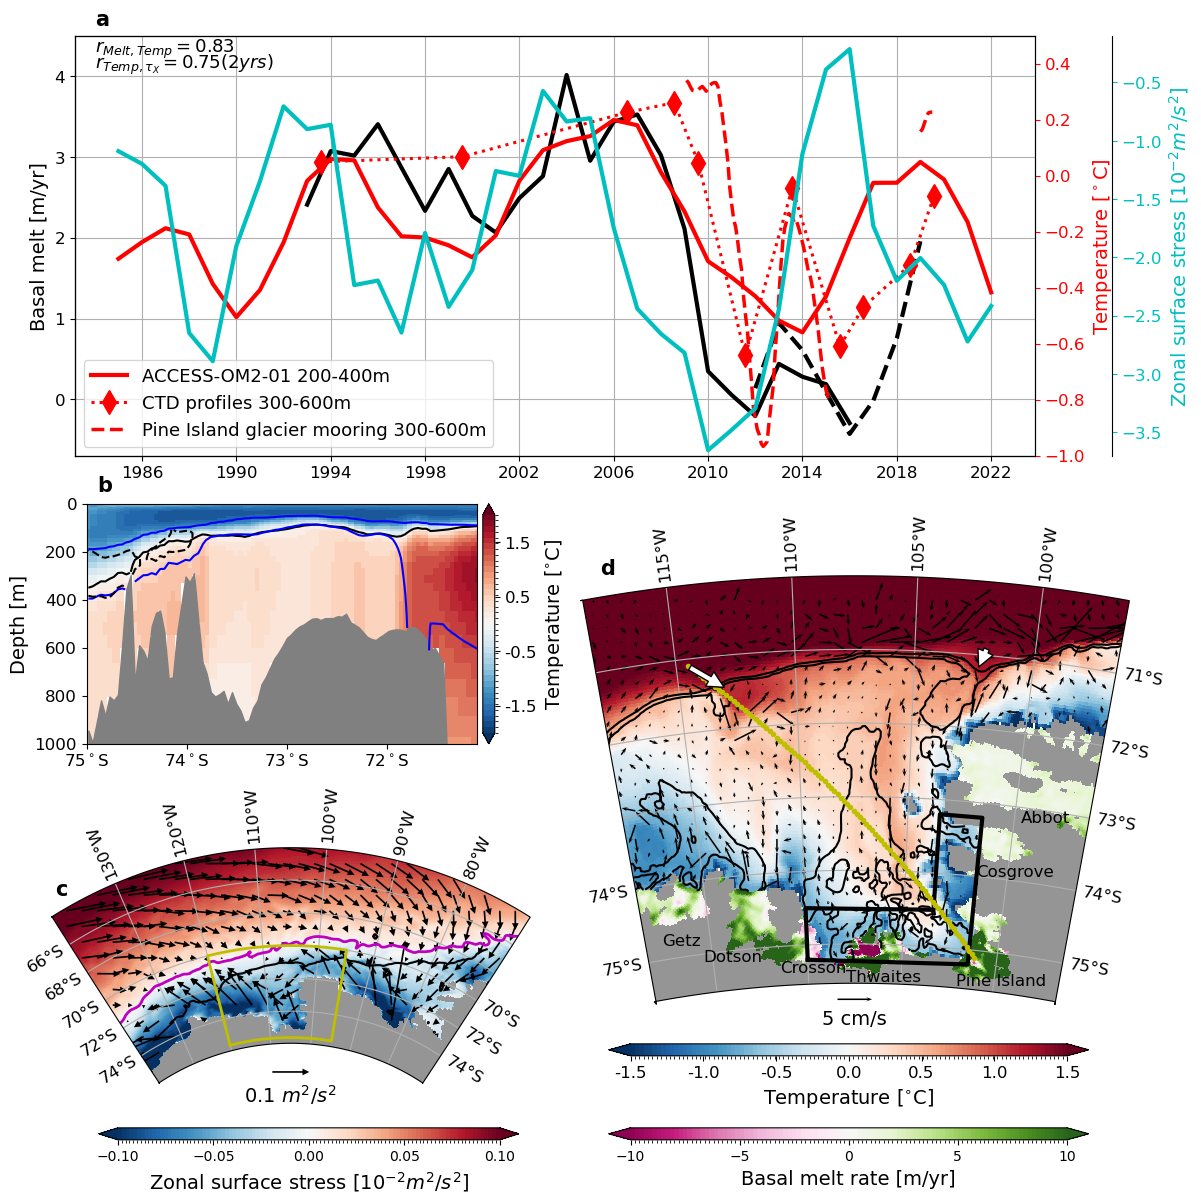

In [23]:
# Plot Figure 1:

contlev = [.7]
boxlons = np.concatenate((np.arange(-120,-94,1),np.arange(-95,-121,-1),[-120]))
boxlats = np.concatenate((np.ones(26)*(-75.609),np.ones(26)*(-70),[-75.609]))

fig = plt.figure(figsize= (12,12))
# Subplot 1: Map of average conditions
ax1 = plt.axes([0.48,0.11,0.46,0.44], projection = projection_pibl)
ax1.set_extent(extent_pibl, crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.bottom_labels = False
gl.left_labels = False
gl.ylocator = mticker.FixedLocator([-75, -74, -73,-72,-71])
gl.xlocator = mticker.FixedLocator([-115, -110, -105,-100])
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax1.set_boundary(boundary_path_pibl, transform=ccrs.PlateCarree())  
p1 = t_clims.plot(ax=ax1,
                    x='xt_ocean', y='yt_ocean', levels = np.linspace(-1.5,1.5,101), add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
p2 = ax1.quiver(u_clims.xu_ocean,u_clims.yu_ocean,u_clims.values,v_clims.values, color = 'k',
               regrid_shape=30,scale=0.8, width=0.0028, headwidth=3, headlength=4, headaxislength=2.5,transform = ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax1,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=1,
                   transform=ccrs.PlateCarree())
land100.plot(ax=ax1,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
plotpat = -melt_dataset.melt_mean.sel(x = slice(-2000000,-1000000)).sel(y =  slice(300000,-1500000))
p4 = plotpat.plot.pcolormesh(ax=ax1,x='lon',y='lat', 
                                levels =np.linspace(-10,10,101), add_colorbar = False, cmap = 'PiYG',
                                transform = ccrs.PlateCarree())
ax1.quiverkey(p2, X=.5, Y =0.02, U=0.05,
             label='5 cm/s', labelpos='S', fontproperties=({'size':14}))

ax1.plot([-110,-101.5,-101.5,-103.5,-103.5,-110,-110],[-75.2,-75.2,-73.2,-73.2,-74.5,-74.5,-75.2],color='k', lw=3, transform=ccrs.PlateCarree())
ax1.set_title('')
# Name glaciers
ax1.text(-115.5,-75.1,'Dotson', color='k', fontsize=12, transform=ccrs.PlateCarree())
ax1.text(-108,-75.5,'Thwaites', color='k', fontsize=12, transform = ccrs.PlateCarree())
ax1.text(-102,-75.5,'Pine Island', color='k', fontsize=12, transform = ccrs.PlateCarree())
ax1.text(-111.5,-75.35,'Crosson',color='k',fontsize=12,transform = ccrs.PlateCarree())
ax1.text(-117.5,-74.8,'Getz',color='k',fontsize=12,transform = ccrs.PlateCarree())
ax1.text(-101.5,-74,'Cosgrove',color='k',fontsize=12,transform=ccrs.PlateCarree())
ax1.text(-99.7,-73.2,'Abbot',color='k',fontsize=12,transform=ccrs.PlateCarree())
ax1.annotate('',xy=(-113, -71.45), xytext=(-114.5, -71.1),
            arrowprops=dict(facecolor='white', shrink=0.05), transform=ccrs.PlateCarree())
ax1.annotate('',xy=(-102.3, -71.18), xytext=(-102, -70.9),
            arrowprops=dict(facecolor='white', shrink=0.05), transform=ccrs.PlateCarree())

# indicate section
ax1.plot(slo2,sla2,color='y', ls='none', marker='o', markersize=3, transform=ccrs.PlateCarree())

# colorbars
axin1 = plt.axes([0.505,0.12,0.4,0.01])
cb=plt.colorbar(p1,cax=axin1,ticks=np.arange(-1.5,2,0.5),orientation='horizontal',aspect = 50)
cb.set_label('Temperature [$^{\circ}$C]',fontsize=14)
cb.set_ticks(np.arange(-1.5,2,0.5), labels=np.arange(-1.5,2,0.5),fontsize=12)
axin2 = plt.axes([0.505,0.05,0.4,0.01])
cb=plt.colorbar(p4,cax=axin2,ticks=np.arange(-10,15,5),orientation='horizontal',aspect = 50)
cb.set_label('Basal melt rate [m/yr]',fontsize=14)
ax1.text(-117.5,-69.7,'d',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())


# ------------------------------
# Subplot two: time series
ax2 = plt.axes([0.06,0.62,0.8,0.35])
# Basal melting on left yaxis: Relative to averages of overlapping period
(-pib_meltid+pib_meltid.sel(time=slice('2011-01-01','2017-12-31')).mean('time')).resample({'time':'Y'}).mean().assign_coords(time = ts_pibsam.time[102:-72:12]).rolling(time=3,center=True).mean().plot(ax=ax2,color='k', lw=3, label='Paolo')
# Davison
(dav_pib_melt-dav_pib_melt.sel(time=slice('2011-01-01','2017-12-31')).mean('time'))[8:-9].resample({'time':'Y'}).mean().assign_coords(time = ts_pibsam.time[330:-36:12]).rolling(time=3,center=True).mean().plot(ax=ax2,color='k', lw=3, ls='--', label='Davison')

# Temperatures on right y-axis
axb = ax2.twinx()
# Surface stress on second right y-axis
axc = ax2.twinx()
axc.spines.right.set_position(("axes", 1.08))
# Temp
axb.plot(ts_pibsa.assign_coords(time = ts_pibsam.time[6::12]).time, (ts_pibsa).assign_coords(time = ts_pibsam.time[6::12]).rolling(time=3,center=True).mean(), 'r', label='ACCESS-OM2-01 200-400m' , lw=3)
# AS Obs
pibavg_xr.sel(lev = slice(300,600)).mean('lev').plot(ax=axb,marker='d', markersize=12, lw=2.2,label='CTD profiles 300-600m',color='r', ls=':')
t_moor.sel(lev = slice(300,600)).mean('lev').rolling(time=13,center=True).mean().plot(ax=axb, lw=2.5,label='Pine Island glacier mooring 300-600m',color='r',ls='--')
t_moor.sel(lev = slice(300,600)).mean('lev').rolling(time=5,center=True).mean()[-30:].plot(ax=axb, lw=2.5,color='r', ls='--')

# Wind stress
p3, = axc.plot(taux_as.assign_coords(time = ts_pibsam.time[6::12]).time,100*(taux_as).assign_coords(time = ts_pibsam.time[6::12]).rolling(time=3, center=True).mean(),color='c', lw=3)

ax2.grid()
ax2.set_ylabel('Basal melt [m/yr]', color ='k',fontsize=14)
ax2.tick_params('y', colors='k', labelsize=12)
ax2.tick_params('x', colors='k', labelsize=12)
ax2.set_ylim([-0.7,4.5])
ax2.set_xlabel('')
ax2.set_xticks(ticks=ts_pibsam.time[30::48])
ax2.text(ts_pibsam.time[6],4.63,'a',color='k',fontsize=15,fontweight='bold')
ax2.text(ts_pibsam.time[6],4.3,'$r_{Melt,Temp} = 0.83$',color='k',fontsize=13)
ax2.text(ts_pibsam.time[6],4.1,r'$r_{Temp,\tau_X} = 0.75 (2yrs)$',color='k',fontsize=13)
ax2.set_title('')
axb.set_ylabel('Temperature [$^\circ$C]', color = 'r',fontsize=14)
axb.tick_params('y', colors='r', labelsize=12)
axb.legend(fontsize=13, loc='lower left')
axb.set_ylim([-1,0.5])

axc.set_ylabel('Zonal surface stress [$10^{-2}m^2/s^2$]', color = 'c',fontsize=14)
axc.set_xlabel('Time',color='k', fontsize=14)
axc.tick_params('y', colors='c', labelsize=12)
axc.set_ylim([-3.7,-0.1])


# ------------------------------
# subplot: Average temperature section
ax3 = plt.axes([0.07,0.38,0.325,0.2])
p1=t_sec_asb.mean('time').plot(ax=ax3,x='yt_ocean',y='st_ocean',levels=np.linspace(-2,2,39),add_colorbar=False, extend='both')
t_sec_asb.mean('time').plot.contour(ax=ax3,x='yt_ocean',y='st_ocean',levels=[0],colors='k')
rho_sec_asb.mean('time').plot.contour(ax=ax3, x='yt_ocean',y='st_ocean',levels = [27.9,28.1], colors='b',alphas=.7)

regsec.sel(st_ocean = slice(100,500)).sel(dim_0 = slice(10,91)).plot.contour(ax=ax3,x='yt_ocean',y='st_ocean',levels=contlev,colors='k',linestyles='--')
ax3.fill_between(ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').yt_ocean,1500,ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest'),color='grey')
ax3.invert_yaxis()
ax3.set_xlim([-75,-71.1])
ax3.set_ylabel('Depth [m]',fontsize=14)
ax3.set_ylim([1000,0])
ax3.tick_params('y', colors='k', labelsize=12)
ax3.tick_params('x', colors='k', labelsize=12)
ax3.text(-74.9,-50,'b',color='k',fontsize=15, fontweight='bold')
ax3.set_xticks([-75,-74,-73,-72],['75$^\circ$S','74$^\circ$S','73$^\circ$S','72$^\circ$S'])
ax3.set_xlabel('')

axin4 = plt.axes([0.4,0.38,0.01,0.2])
cb=plt.colorbar(p1,cax=axin4,ticks=np.arange(-1.5,2.5,1),orientation='vertical',aspect = 50)
cb.set_label('Temperature [$^{\circ}$C]',fontsize=14)
cb.set_ticks(np.arange(-1.5,2.5,1), labels=np.arange(-1.5,2.5,1),fontsize=12)


# ------------------------------
# subplot: Map of average wind stress:
ax5 = plt.axes([0.04,0.055,0.4,0.28], projection = projection_wa)
ax5.set_extent(extent_wa, crs=ccrs.PlateCarree())
gl = ax5.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.bottom_labels = False
gl.right_labels = False
gl.ylocator = mticker.FixedLocator([-76, -74, -72,-70,-68,-66,-64])
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax5.set_boundary(boundary_path_wa, transform=ccrs.PlateCarree())
p1=taux_an.mean('time').plot(ax=ax5, levels=np.linspace(-0.1,0.1,101), add_colorbar=False, transform=ccrs.PlateCarree(), extend='both')
taux_an.mean('time').plot.contour(ax=ax5, levels=[0],linewidths=2,colors='m', transform=ccrs.PlateCarree())
ht.sel(yt_ocean = slice(-73.2,-67)).plot.contour(ax=ax5,levels=[1000],linewidths=1.5,colors='k', transform=ccrs.PlateCarree())
p2 = ax5.quiver(taux_an.xu_ocean,taux_an.yu_ocean,taux_an.mean('time').values,tauy_an.mean('time').values, color = 'k',
               regrid_shape=16,scale=1.3, width=0.0035, headwidth=4, headlength=4, headaxislength=4,transform = ccrs.PlateCarree())
land_u.plot(ax=ax5,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
ax5.plot(boxlons,boxlats,color='y',lw=2,transform=ccrs.PlateCarree())

axin3 = plt.axes([0.08,0.05,0.35,0.01])
cb=plt.colorbar(p1,cax=axin3,ticks=np.arange(-0.1,0.15,0.05),orientation='horizontal',aspect = 50)
cb.set_label('Zonal surface stress [$10^{-2}m^2/s^2$]',fontsize=14)
ax5.quiverkey(p2, X=.5, Y =0.05, U=0.1,
             label='0.1 $m^2/s^2$', labelpos='S', fontproperties=({'size':14}))
ax5.text(-138,-63,'c',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())


#plt.savefig('/home/581/or6852/plots/figures/fig1_v14.png', dpi=350)